# Setup

In [17]:
!pip install imblearn
!pip uninstall scikit-learn --yes
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,precision_score, recall_score,mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imblearn 0.0
Uninstalling imblearn-0.0:
  Successfully uninstalled imblearn-0.0
  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl (8.4 MB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [18]:
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment(f"/Equipo_4/Absenteeism_at_work/Fase3")

<Experiment: artifact_location='mlflow-artifacts:/11', creation_time=1730681093882, experiment_id='11', last_update_time=1730681093882, lifecycle_stage='active', name='/Equipo_4/Absenteeism_at_work/Fase3', tags={}>

In [19]:
class DataHandler:
    """
    A utility class for handling data-related tasks, including loading, preparing, and visualizing datasets. 
    This class provides static methods for these tasks, enabling direct calls without needing an instance.
    """

    @staticmethod
    def load_data(filepath, sep=";"):
        """
        Loads data from a CSV file.

        Parameters:
        - filepath (str): The file path to the CSV file.
        - sep (str): The delimiter to use when reading the CSV file. Default is ";".
        
        Returns:
        - pd.DataFrame: The loaded data as a DataFrame.
        """
        if isinstance(filepath, int):
            raise ValueError("El parámetro 'filepath no puede ser de tipo 'int'.")
        print("1.- Loading and exploring the data")
        data = pd.read_csv(filepath, sep=sep)
        return data

    @staticmethod
    def prepared_data(data):
        """
        Prepares the data by showing summary statistics, checking for missing values, and removing rows with null values.

        Parameters:
        - data (pd.DataFrame): The input DataFrame to be prepared.
        
        Returns:
        - pd.DataFrame: A cleaned DataFrame with no missing values.
        """
        if isinstance(data, int):
            raise ValueError("El parámetro 'data' no puede ser de tipo 'int'.")
        print("2.- Preparing the data")
        print(data.describe())
        print("Number of rows in the dataset:", data.shape[0])
        print("Number of columns in the dataset:", data.shape[1])
        print("\nFirst rows of the dataset:")
        print(data.head())

        # Check for missing values
        print("\nChecking for missing values:")
        missing_data_summary = data.isnull().sum()
        print(missing_data_summary)

        # Drop rows with missing values
        df_cleaned = data.dropna()
        print("\nMissing values after cleaning:")
        print(df_cleaned.isnull().sum())

        # Summary of the cleaned DataFrame
        print("\nSummary of the cleaned DataFrame:")
        print(df_cleaned.info())

        return df_cleaned

    @staticmethod
    def plot_histograms(data):
        """
        Plots histograms for each numerical feature in the dataset.

        Parameters:
        - data (pd.DataFrame): The input DataFrame to plot histograms from.
        """
        if isinstance(data, int):
            raise ValueError("El parámetro 'data' no puede ser de tipo 'int'.")
        data.hist(bins=15, figsize=(15, 10))
        plt.show()

    @staticmethod
    def plot_correlation_matrix(data):
        """
        Plots a correlation matrix for numerical features in the dataset.

        Parameters:
        - data (pd.DataFrame): The input DataFrame to plot the correlation matrix from.
        """
        if isinstance(data, int):
            raise ValueError("El parámetro 'data' no puede ser de tipo 'int'.")
        plt.figure(figsize=(12, 8))
        sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.show()

    @staticmethod
    def plot_feature_relationships(data, target):
        """
        Plots boxplots for numerical features to show their relationships with a target variable.

        Parameters:
        - data (pd.DataFrame): The input DataFrame to plot relationships from.
        - target (str): The target variable to consider in the plot title.
        """
        if isinstance(data, int):
            raise ValueError("El parámetro 'data' no puede ser de tipo 'int'.")
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=data)
        plt.xticks(rotation=90)
        plt.title(f'Box plot of all numerical variables with respect to {target}')
        plt.show()
    
    @staticmethod
    def versioned_data(data):
        """
        Saves a versioned copy of the data to a CSV file and generates a hash for data versioning.

        Parameters:
        - data (pd.DataFrame): The DataFrame to be versioned and saved.
        """
        if isinstance(data, int):
            raise ValueError("El parámetro 'data' no puede ser de tipo 'int'.")
        print("3.- Versioning the data")
        data.to_csv('absenteeism_data.csv', index=False)
        print("Data version: v1")
        print("File hash:", hash(tuple(data.values.tobytes())))

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

class Preprocessor:
    """
    A class for preprocessing data, including scaling numeric features,
    encoding categorical features, and applying PCA for dimensionality reduction.
    """

    def scale_features(self, data, numeric_columns):
        """
        Scales numeric columns in the provided DataFrame using StandardScaler.

        Parameters:
        data (DataFrame): The DataFrame containing the data to be scaled.
        numeric_columns (list): A list of column names to scale.

        Returns:
        DataFrame: A DataFrame with scaled numeric columns.

        Raises:
        ValueError: If the input `data` is of type `int`.
        """
        if isinstance(data, int):
            raise ValueError("El parámetro 'data' no puede ser de tipo 'int'.")
        
        scaler = StandardScaler()
        data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
        return data

    def encode_categorical_columns(self, data, categorical_columns):
        """
        Encodes categorical columns in the provided DataFrame using LabelEncoder.

        Parameters:
        data (DataFrame): The DataFrame containing the data to be encoded.
        categorical_columns (list): A list of column names to encode.

        Returns:
        DataFrame: A DataFrame with encoded categorical columns.

        Raises:
        ValueError: If the input `data` is of type `int`.
        """
        if isinstance(data, int):
            raise ValueError("El parámetro 'data' no puede ser de tipo 'int'.")
        
        label_encoder = LabelEncoder()
        for col in categorical_columns:
            data[col] = label_encoder.fit_transform(data[col])
        return data

    def apply_pca(self, data, numeric_columns, n_components=2):
        """
        Applies Principal Component Analysis (PCA) on numeric columns to reduce dimensionality.

        Parameters:
        data (DataFrame): The DataFrame containing the data for PCA.
        numeric_columns (list): A list of column names to apply PCA on.
        n_components (int, optional): The number of principal components to retain. Default is 2.

        Returns:
        DataFrame: A DataFrame with new columns for the PCA components.

        Raises:
        ValueError: If the input `data` is of type `int`.
        """
        if isinstance(data, int):
            raise ValueError("El parámetro 'data' no puede ser de tipo 'int'.")
        
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(data[numeric_columns])
        data['PCA1'] = pca_result[:, 0]
        data['PCA2'] = pca_result[:, 1]
        return data

    def preprocess_data(self, df, numeric_columns, categorical_columns):
        """
        Preprocesses the data by scaling numeric features, encoding categorical features, 
        and applying PCA for dimensionality reduction.

        Parameters:
        df (DataFrame): The DataFrame to preprocess.
        numeric_columns (list): A list of numeric columns to scale and apply PCA on.
        categorical_columns (list): A list of categorical columns to encode.

        Returns:
        DataFrame: A fully preprocessed DataFrame with scaled, encoded, and PCA-transformed data.

        Raises:
        ValueError: If the input `df` is of type `int`.
        """
        if isinstance(df, int):
            raise ValueError("El parámetro 'df' no puede ser de tipo 'int'.")
        
        df = self.scale_features(df, numeric_columns)
        df = self.encode_categorical_columns(df, categorical_columns)
        df = self.apply_pca(df, numeric_columns)
        return df


In [20]:
class ModelTraining:
    """
    A class for training and evaluating machine learning models, including model
    definition, hyperparameter selection, data splitting, and model evaluation.
    """

    def define_models(self):
        """
        Defines a dictionary of machine learning models for classification.

        Returns:
        dict: A dictionary where keys are model names and values are classifier instances.
        """
        return {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
        }
    
    def define_hyperparameters(self):
        """
        Defines a dictionary of hyperparameters for each model to be used in grid search.

        Returns:
        dict: A dictionary where keys are model names and values are dictionaries of hyperparameters.
        """
        return {
            'Logistic Regression': {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__solver': ['lbfgs', 'liblinear']
            },
            'Random Forest': {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [None, 10, 20],
                'classifier__min_samples_split': [2, 5]
            },
            'Gradient Boosting': {
                'classifier__n_estimators': [100, 200],
                'classifier__learning_rate': [0.05, 0.1],
                'classifier__max_depth': [3, 5]
            },
            'K-Nearest Neighbors': {
                'classifier__n_neighbors': [3, 5, 7],
                'classifier__weights': ['uniform', 'distance']
            }
        }

    def split_data(self, data, target, test_size=0.2, random_state=42):
        """
        Splits data into training and testing sets.

        Parameters:
        data (DataFrame): The DataFrame containing features and target.
        target (str): The name of the target column.
        test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
        random_state (int, optional): The random state for reproducibility. Default is 42.

        Returns:
        tuple: A tuple containing training and testing sets (X_train, X_test, y_train, y_test).

        Raises:
        ValueError: If the input `data` is of type `int`.
        """
        if isinstance(data, int):
            raise ValueError("El parámetro 'data' no puede ser de tipo 'int'.")
        
        X = data.drop(target, axis=1)
        y = data[target]
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

    def get_best_model(self, param_grid, model_pipeline, X_train, y_train, model_name):
        """
        Performs grid search to find the best model based on hyperparameters.

        Parameters:
        param_grid (dict): The hyperparameter grid for grid search.
        model_pipeline (Pipeline): The pipeline containing the model and preprocessing steps.
        X_train (DataFrame): The training feature set.
        y_train (Series): The training target set.
        model_name (str): The name of the model for display purposes.

        Returns:
        estimator: The best model estimator found during grid search.

        Raises:
        ValueError: If the input `model_name` is of type `int`.
        """
        if isinstance(model_name, int):
            raise ValueError("El parámetro 'model_name' no puede ser de tipo 'int'.")
        
        grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=2), scoring='accuracy')
        grid_search.fit(X_train, y_train)
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        return grid_search.best_estimator_

    def evaluate_classification_model(self, model, X_test, y_test):
        """
        Evaluates a classification model using accuracy, classification report, and confusion matrix.

        Parameters:
        model: The trained model to evaluate.
        X_test (DataFrame): The test feature set.
        y_test (Series): The true labels for the test set.

        Returns:
        tuple: A tuple containing accuracy, classification report, confusion matrix, and predictions.

        Raises:
        ValueError: If the input `model` is of type `int`.
        """
        if isinstance(model, int):
            raise ValueError("El parámetro 'model' no puede ser de tipo 'int'.")
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        return accuracy, report, cm, y_pred

    def plot_confusion_matrix(self, cm, model_name):
        """
        Plots the confusion matrix for a classification model.

        Parameters:
        cm (array): The confusion matrix to plot.
        model_name (str): The name of the model for display purposes.

        Raises:
        ValueError: If the input `model_name` is of type `int`.
        """
        if isinstance(model_name, int):
            raise ValueError("El parámetro 'model_name' no puede ser de tipo 'int'.")
        
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Matriz de Confusión - {model_name}')
        plt.ylabel('Etiqueta verdadera')
        plt.xlabel('Etiqueta predicha')
        plt.show()

    def plot_feature_importance(self, model, feature_names, model_name):
        """
        Plots feature importance for tree-based models.

        Parameters:
        model: The trained model with feature importances.
        feature_names (list): List of feature names.
        model_name (str): The name of the model for display purposes.

        Raises:
        ValueError: If the input `model` is of type `int`.
        """
        if isinstance(model, int):
            raise ValueError("El parámetro 'model' no puede ser de tipo 'int'.")
        
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)[::-1]
        plt.figure(figsize=(10, 6))
        plt.barh([feature_names[i] for i in sorted_idx], importance[sorted_idx], color="b")
        plt.title(f'Importancia de características - {model_name}')
        plt.show()


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
import mlflow
import mlflow.sklearn
import numpy as np

class ModelEvaluation:
    """
    A class for training and evaluating machine learning models with and without
    class balancing, including logging metrics and models to MLflow.
    """

    def train_and_evaluate_models(self, models, param_grids, X_train, y_train, X_test, y_test):
        """
        Trains and evaluates models without class balancing, logs results to MLflow, 
        and displays performance metrics.

        Parameters:
        models (dict): A dictionary of models to train and evaluate.
        param_grids (dict): A dictionary of hyperparameter grids for each model.
        X_train (DataFrame): The training feature set.
        y_train (Series): The training target set.
        X_test (DataFrame): The test feature set.
        y_test (Series): The test target set.

        Raises:
        ValueError: If the input `models` is of type `int`.
        """
        if isinstance(models, int):
            raise ValueError("El parámetro 'models' no puede ser de tipo 'int'.")

        for model_name, model in models.items():
            print(f"\nTraining {model_name}...")

            # Set up MLflow to log experiment
            mlflow.set_tracking_uri("http://localhost:5001")
            mlflow.set_experiment(f"ML_Models_Absenteeism_Equipo4_{model_name}")

            with mlflow.start_run(nested=True) as run:
                mlflow.log_param("model_name", model_name)

                # Create model pipeline
                model_pipeline = Pipeline(steps=[('classifier', model)])
                best_model = ModelTraining().get_best_model(param_grids[model_name], model_pipeline, X_train, y_train, model_name)

                # Evaluate model and log metrics to MLflow
                accuracy, report, cm, y_pred = ModelTraining().evaluate_classification_model(best_model, X_test, y_test)
                
                # Calculate precision and recall
                precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

                # Log metrics to MLflow
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)

                print(f"{model_name} Accuracy: {accuracy}\n")
                print(f"Classification Report for {model_name}:\n{report}\n")
                ModelTraining().plot_confusion_matrix(cm, model_name)

                # Log model to MLflow
                mlflow.sklearn.log_model(best_model, "model")
                print(f"Modelo registrado en MLflow para {model_name}")

                # Cross-validation
                cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=StratifiedKFold(n_splits=2), scoring='accuracy')
                mlflow.log_metric("cross_val_accuracy", np.mean(cross_val_scores))
                print(f"{model_name} Cross-Validation Accuracy: {np.mean(cross_val_scores)}\n")

                # Feature importance for specific models
                if model_name in ['Random Forest', 'Gradient Boosting']:
                    ModelTraining().plot_feature_importance(best_model.named_steps['classifier'], X_train.columns, model_name)

    def train_and_evaluate_models_with_balancing(self, models, param_grids, X_train, y_train, X_test, y_test):
        """
        Trains and evaluates models with class balancing, logs results to MLflow, 
        and displays performance metrics.

        Parameters:
        models (dict): A dictionary of models to train and evaluate.
        param_grids (dict): A dictionary of hyperparameter grids for each model.
        X_train (DataFrame): The training feature set.
        y_train (Series): The training target set.
        X_test (DataFrame): The test feature set.
        y_test (Series): The test target set.

        Raises:
        ValueError: If the input `models` is of type `int`.
        """
        if isinstance(models, int):
            raise ValueError("El parámetro 'models' no puede ser de tipo 'int'.")

        # Apply RandomOverSampler to balance training data
        print("\nApplying RandomOverSampler for class balancing...")
        ros = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
        print(f"New shapes - X_train: {X_train_resampled.shape}, y_train: {y_train_resampled.shape}")

        for model_name, model in models.items():
            print(f"\nTraining {model_name} with balanced data...")

            # Set up MLflow to log experiment
            mlflow.set_tracking_uri("http://localhost:5001")
            mlflow.set_experiment(f"ML_Models_Absenteeism_Equipo4_Balanced_{model_name}")

            with mlflow.start_run(nested=True) as run:
                mlflow.log_param("model_name", model_name)

                # Create model pipeline
                model_pipeline = Pipeline(steps=[('classifier', model)])
                best_model = ModelTraining().get_best_model(param_grids[model_name], model_pipeline, X_train_resampled, y_train_resampled, model_name)

                # Evaluate model and log metrics to MLflow
                accuracy, report, cm, y_pred = ModelTraining().evaluate_classification_model(best_model, X_test, y_test)
                
                # Calculate precision and recall
                precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

                # Log metrics to MLflow
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)

                print(f"{model_name} Accuracy: {accuracy}\n")
                print(f"Classification Report for {model_name}:\n{report}\n")
                ModelTraining().plot_confusion_matrix(cm, model_name)

                # Log model to MLflow
                mlflow.sklearn.log_model(best_model, "model")
                print(f"Modelo registrado en MLflow para {model_name}")

                # Cross-validation
                cross_val_scores = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=StratifiedKFold(n_splits=2), scoring='accuracy')
                mlflow.log_metric("cross_val_accuracy", np.mean(cross_val_scores))
                print(f"{model_name} Cross-Validation Accuracy: {np.mean(cross_val_scores)}\n")

                # Feature importance for specific models
                if model_name in ['Random Forest', 'Gradient Boosting']:
                    ModelTraining().plot_feature_importance(best_model.named_steps['classifier'], X_train.columns, model_name)


In [22]:
def main(filepath):
    """
    The main function orchestrates the data loading, preprocessing, model training, 
    and evaluation process. It includes initial model training and evaluation, 
    as well as the application of best practices such as class balancing.

    Parameters:
    filepath (str): The file path to the dataset for loading and processing.
    """

    # 1. Load and prepare data
    data = DataHandler.load_data(filepath)
    df_cleaned = DataHandler.prepared_data(data)
   
    # 2. Data exploration and preprocessing
    # Generate visualizations for understanding data distribution and relationships
    DataHandler.plot_histograms(df_cleaned)
    DataHandler.plot_correlation_matrix(df_cleaned)
    DataHandler.plot_feature_relationships(df_cleaned, 'Absenteeism time in hours')

    # Define numeric and categorical columns for preprocessing
    numeric_columns = ['Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target']
    categorical_columns = ['Month of absence', 'Day of the week', 'Seasons', 'Education', 'Disciplinary failure', 'Social drinker', 'Social smoker']

    # Preprocess the data by scaling numeric features, encoding categorical features, and applying PCA
    preprocessor = Preprocessor()
    df_preprocessed = preprocessor.preprocess_data(df_cleaned, numeric_columns, categorical_columns)

    # 4. Split the data for training and evaluation
    model_training = ModelTraining()
    X_train, X_test, y_train, y_test = model_training.split_data(df_preprocessed, 'Absenteeism time in hours')

    # Define models and hyperparameters for training
    models = model_training.define_models()
    param_grids = model_training.define_hyperparameters()

    # Initial model training and evaluation
    print("\n### Initial Training and Evaluation ###")
    model_evaluation = ModelEvaluation()
    model_evaluation.train_and_evaluate_models(models, param_grids, X_train, y_train, X_test, y_test)

    # 5. Apply best practices in the modeling pipeline, including class balancing and hyperparameter optimization
    print("\n### Applying Best Practices ###")
    model_evaluation.train_and_evaluate_models_with_balancing(models, param_grids, X_train, y_train, X_test, y_test)


# Unit Testing (Pruebas Unitarias)

Se prueba para cada clase no estática que se respete el tipo de valor de los parámetros del método.

In [23]:
import unittest

class TestDataHandler(unittest.TestCase):
    """
    Unit test class for testing methods within the DataHandler class.
    Each test method uses self.assertRaises to check for expected exceptions 
    when passing invalid inputs to DataHandler methods.
    """
    
    def setUp(self):
        """
        Set up a DataHandler instance before each test method.
        """
        self.data_handler = DataHandler()
        
    def test_load_data(self):
        """
        Test the load_data method of DataHandler.
        Checks if ValueError is raised when an invalid argument is passed.
        """
        self.assertRaises(ValueError, self.data_handler.load_data, 1)
    
    def test_prepared_data(self):
        """
        Test the prepared_data method of DataHandler.
        Checks if ValueError is raised when an invalid argument is passed.
        """
        self.assertRaises(ValueError, self.data_handler.prepared_data, 1)
    
    def test_plot_histograms(self):
        """
        Test the plot_histograms method of DataHandler.
        Checks if ValueError is raised when an invalid argument is passed.
        """
        self.assertRaises(ValueError, self.data_handler.plot_histograms, 1)
    
    def test_plot_correlation_matrix(self):
        """
        Test the plot_correlation_matrix method of DataHandler.
        Checks if ValueError is raised when an invalid argument is passed.
        """
        self.assertRaises(ValueError, self.data_handler.plot_correlation_matrix, 1)
    
    def test_plot_feature_relationships(self):
        """
        Test the plot_feature_relationships method of DataHandler.
        Checks if ValueError is raised when invalid arguments are passed.
        """
        self.assertRaises(ValueError, self.data_handler.plot_feature_relationships, 1, 2)
    
    def test_versioned_data(self):
        """
        Test the versioned_data method of DataHandler.
        Checks if ValueError is raised when an invalid argument is passed.
        """
        self.assertRaises(ValueError, self.data_handler.versioned_data, 1)


class TestModelTraining(unittest.TestCase):
    """
    Unit test class for testing methods within the ModelTraining class.
    Each test method uses self.assertRaises to check for expected exceptions 
    when passing invalid inputs to ModelTraining methods.
    """
    
    def setUp(self):
        """
        Set up a ModelTraining instance before each test method.
        """
        self.model_training = ModelTraining()
    
    def test_split_data(self):
        """
        Test the split_data method of ModelTraining.
        Checks if ValueError is raised when invalid arguments are passed.
        """
        self.assertRaises(ValueError, self.model_training.split_data, 1, 2, 3, 4)
    
    def test_get_best_model(self):
        """
        Test the get_best_model method of ModelTraining.
        Checks if ValueError is raised when invalid arguments are passed.
        """
        self.assertRaises(ValueError, self.model_training.get_best_model, 1, 2, 3, 4, 5)
    
    def test_evaluation_classification_model(self):
        """
        Test the evaluate_classification_model method of ModelTraining.
        Checks if ValueError is raised when invalid arguments are passed.
        """
        self.assertRaises(ValueError, self.model_training.evaluate_classification_model, 1, 2, 3)
    
    def test_plot_confusion_matrix(self):
        """
        Test the plot_confusion_matrix method of ModelTraining.
        Checks if ValueError is raised when invalid arguments are passed.
        """
        self.assertRaises(ValueError, self.model_training.plot_confusion_matrix, 1, 2)
    
    def test_plot_feature_importance(self):
        """
        Test the plot_feature_importance method of ModelTraining.
        Checks if ValueError is raised when invalid arguments are passed.
        """
        self.assertRaises(ValueError, self.model_training.plot_feature_importance, 1, 2, 3)


class TestModelEvaluation(unittest.TestCase):
    """
    Unit test class for testing methods within the ModelEvaluation class.
    Each test method uses self.assertRaises to check for expected exceptions 
    when passing invalid inputs to ModelEvaluation methods.
    """
    
    def setUp(self):
        """
        Set up a ModelEvaluation instance before each test method.
        """
        self.model_evaluation = ModelEvaluation()
    
    def test_train_and_evaluate_models(self):
        """
        Test the train_and_evaluate_models method of ModelEvaluation.
        Checks if ValueError is raised when invalid arguments are passed.
        """
        self.assertRaises(ValueError, self.model_evaluation.train_and_evaluate_models, 1, 2, 3, 4, 5, 6)
    
    def test_train_and_evaluate_models_with_balancing(self):
        """
        Test the train_and_evaluate_models_with_balancing method of ModelEvaluation.
        Checks if ValueError is raised when invalid arguments are passed.
        """
        self.assertRaises(ValueError, self.model_evaluation.train_and_evaluate_models_with_balancing, 1, 2, 3, 4, 5, 6)
        
        
# Run the unit tests with increased verbosity
unittest.main(argv=[''], verbosity=2, exit=False)


test_load_data (__main__.TestDataHandler.test_load_data)
Test the load_data method of DataHandler. ... ok
test_plot_correlation_matrix (__main__.TestDataHandler.test_plot_correlation_matrix)
Test the plot_correlation_matrix method of DataHandler. ... ok
test_plot_feature_relationships (__main__.TestDataHandler.test_plot_feature_relationships)
Test the plot_feature_relationships method of DataHandler. ... ok
test_plot_histograms (__main__.TestDataHandler.test_plot_histograms)
Test the plot_histograms method of DataHandler. ... ok
test_prepared_data (__main__.TestDataHandler.test_prepared_data)
Test the prepared_data method of DataHandler. ... ok
test_versioned_data (__main__.TestDataHandler.test_versioned_data)
Test the versioned_data method of DataHandler. ... ok
test_train_and_evaluate_models (__main__.TestModelEvaluation.test_train_and_evaluate_models)
Test the train_and_evaluate_models method of ModelEvaluation. ... ok
test_train_and_evaluate_models_with_balancing (__main__.TestMode

# Correr Main

1.- Loading and exploring the data
2.- Preparing the data
               ID  Reason for absence  Month of absence  Day of the week  \
count  740.000000          740.000000        740.000000       740.000000   
mean    18.017568           19.216216          6.324324         3.914865   
std     11.021247            8.433406          3.436287         1.421675   
min      1.000000            0.000000          0.000000         2.000000   
25%      9.000000           13.000000          3.000000         3.000000   
50%     18.000000           23.000000          6.000000         4.000000   
75%     28.000000           26.000000          9.000000         5.000000   
max     36.000000           28.000000         12.000000         6.000000   

          Seasons  Transportation expense  Distance from Residence to Work  \
count  740.000000              740.000000                       740.000000   
mean     2.544595              221.329730                        29.631081   
std      1.111831      

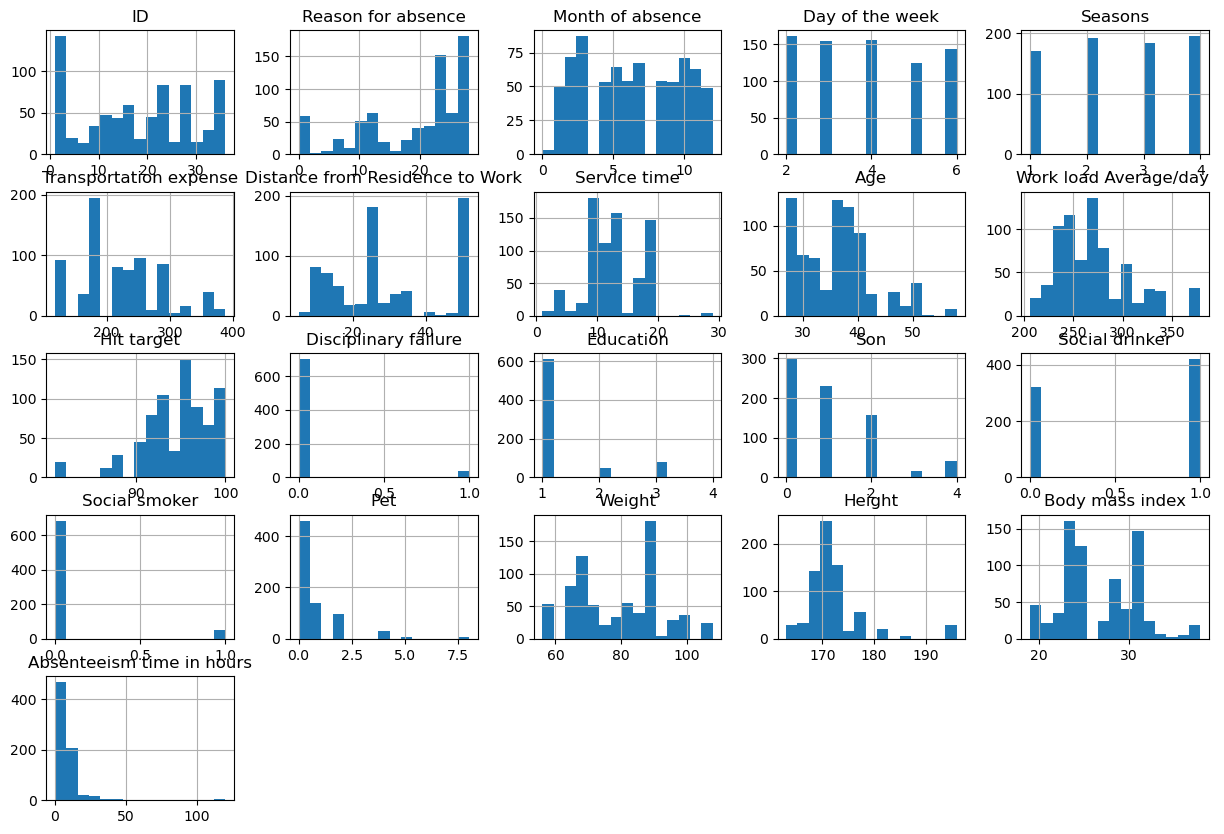

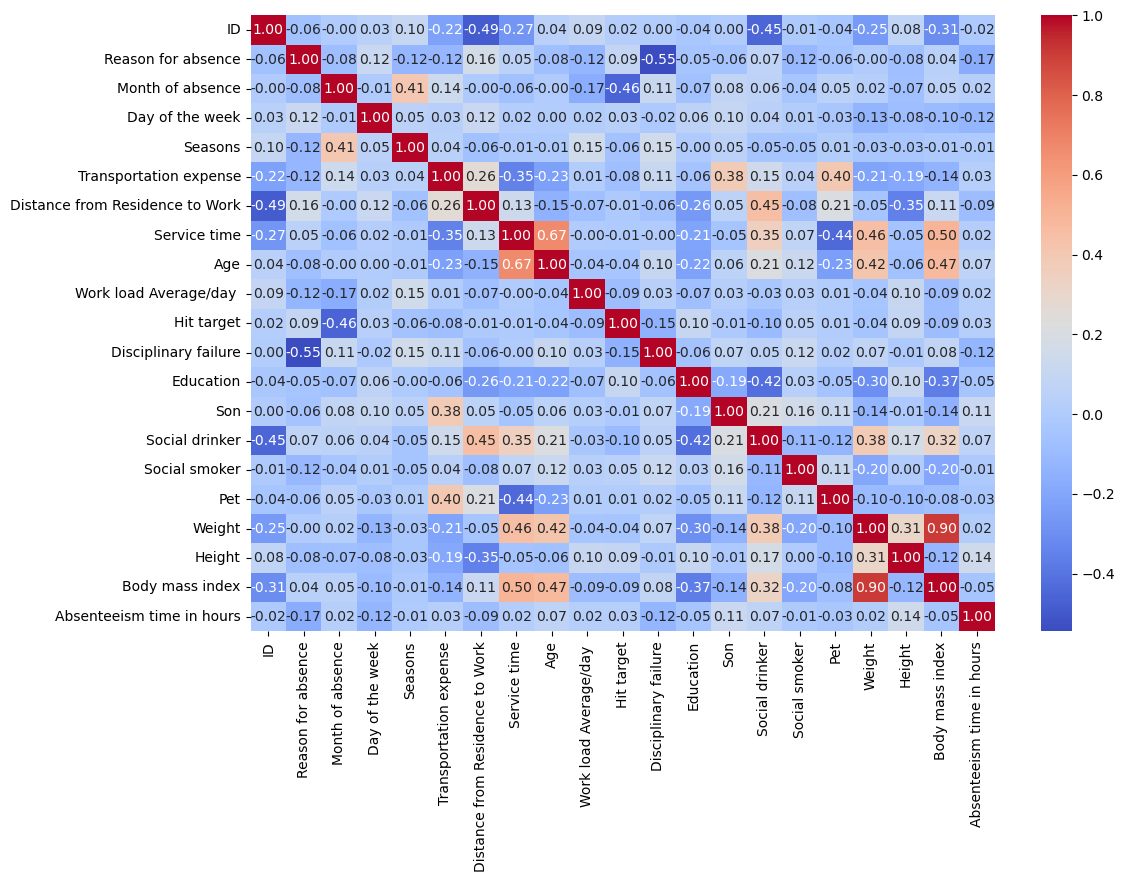

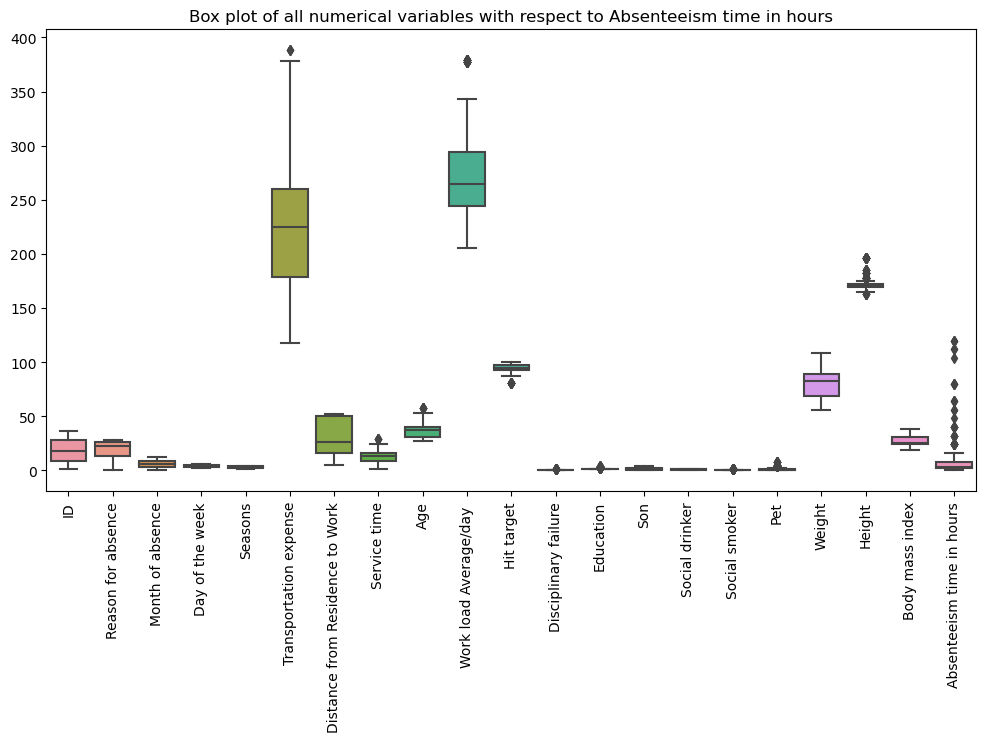


### Initial Training and Evaluation ###

Training Logistic Regression...


/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

Best parameters for Logistic Regression: {'classifier__C': 0.01, 'classifier__solver': 'lbfgs'}
Logistic Regression Accuracy: 0.47297297297297297

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.09      0.05      0.07        19
           2       0.54      0.58      0.56        33
           3       0.21      0.16      0.18        19
           4       0.75      0.25      0.38        12
           5       0.00      0.00      0.00         2
           8       0.50      0.83      0.62        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          80       0.00      0.00      0.00         2

    accuracy                           0.47       148
   macro avg       0.23      0.23      0.21     

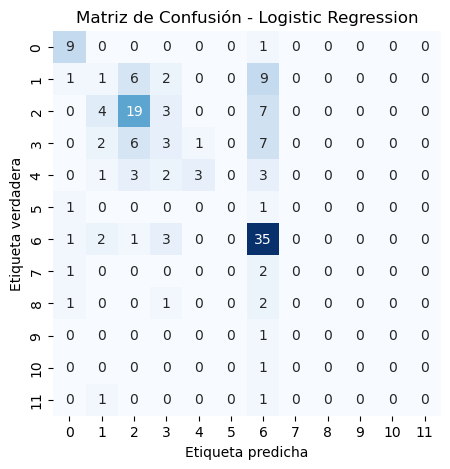

2024/11/03 18:48:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Logistic Regression


/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

Logistic Regression Cross-Validation Accuracy: 0.44425675675675674


Training Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Random Forest Accuracy: 0.47297297297297297

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.27      0.21      0.24        19
           2       0.50      0.39      0.44        33
           3       0.37      0.37      0.37        19
           4       0.29      0.33      0.31        12
           5       0.00      0.00      0.00         2
           8       0.51      0.76      0.61        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          80       0.00      0.00 

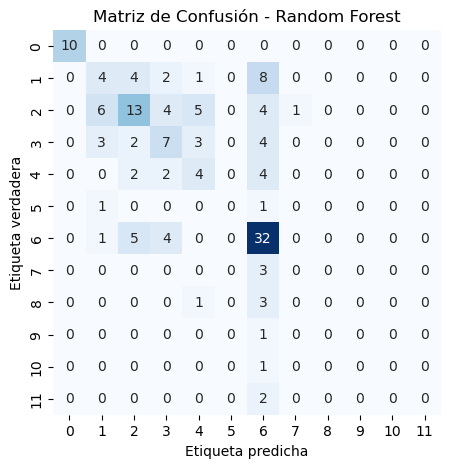

2024/11/03 18:48:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Random Forest


/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Random Forest Cross-Validation Accuracy: 0.4898648648648648



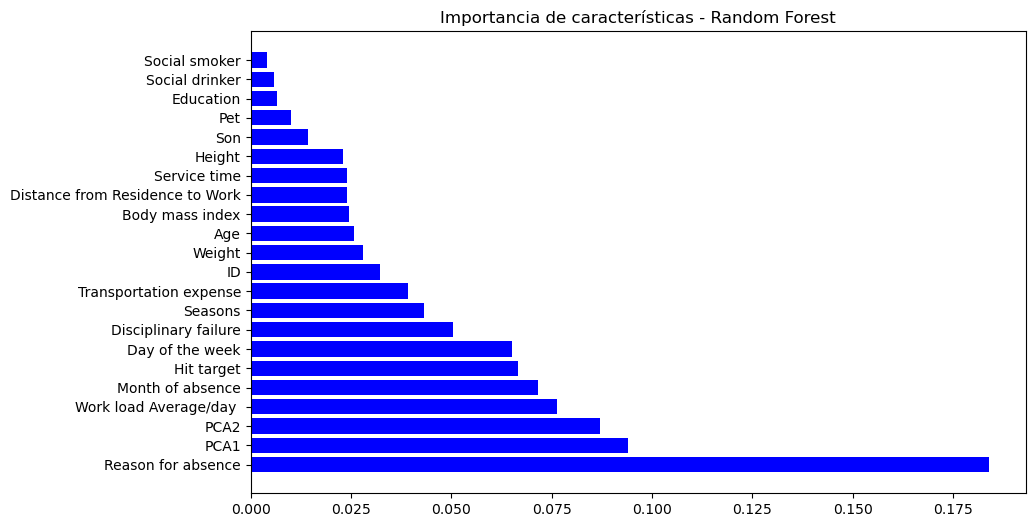

2024/11/03 18:48:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-crab-437 at: http://localhost:5001/#/experiments/4/runs/865ea83b262f4149a6702b73e025f812.
2024/11/03 18:48:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/4.
/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(



Training Gradient Boosting...
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Gradient Boosting Accuracy: 0.4864864864864865

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.23      0.16      0.19        19
           2       0.53      0.52      0.52        33
           3       0.33      0.37      0.35        19
           4       0.36      0.33      0.35        12
           5       0.00      0.00      0.00         2
           8       0.57      0.74      0.65        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          64       0.00      0.00      0.00         0
          80       0.00      0.00    

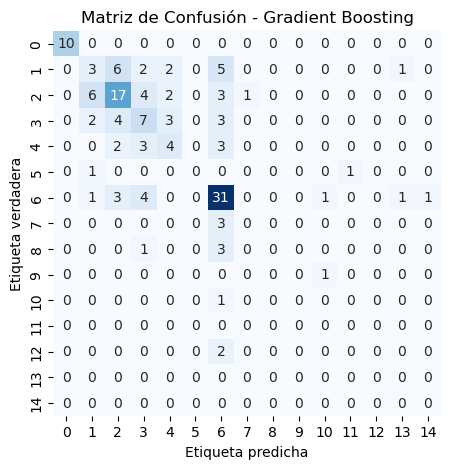

2024/11/03 18:48:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Gradient Boosting


/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Gradient Boosting Cross-Validation Accuracy: 0.47297297297297297



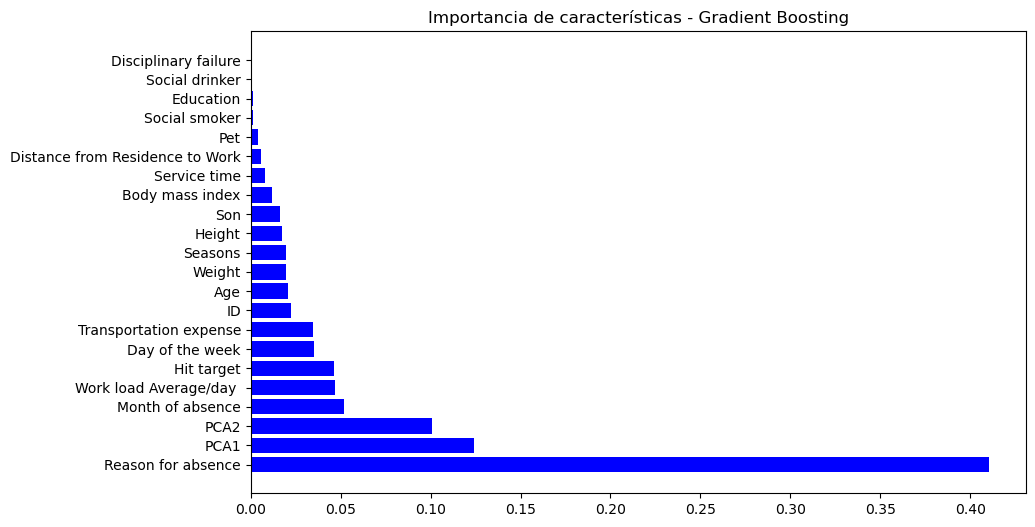

2024/11/03 18:48:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-elk-366 at: http://localhost:5001/#/experiments/5/runs/037288976be843de905aa40ee59c905d.
2024/11/03 18:48:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/5.
/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(



Training K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
K-Nearest Neighbors Accuracy: 0.42567567567567566

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.14      0.16      0.15        19
           2       0.42      0.39      0.41        33
           3       0.33      0.37      0.35        19
           4       0.29      0.17      0.21        12
           5       0.00      0.00      0.00         2
           8       0.51      0.67      0.58        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          80       0.00      0.00      0.00         2

    accuracy                           0.43       148
   ma

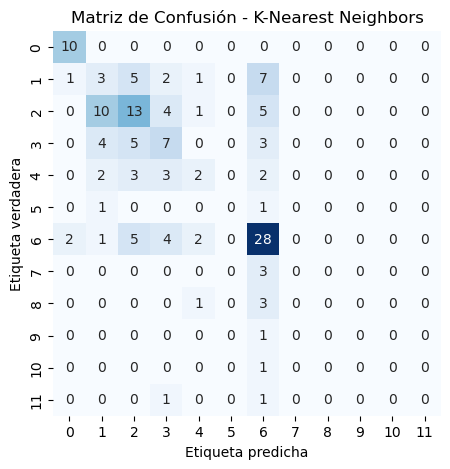

2024/11/03 18:49:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
2024/11/03 18:49:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-rat-620 at: http://localhost:5001/#/experiments/6/runs/a323c3dc63a34d73a3fe4b3e5ed035c3.
2024/11/03 18:49:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/6.


Modelo registrado en MLflow para K-Nearest Neighbors
K-Nearest Neighbors Cross-Validation Accuracy: 0.41216216216216217


### Applying Best Practices ###

Applying RandomOverSampler for class balancing...
New shapes - X_train: (3154, 22), y_train: (3154,)

Training Logistic Regression with balanced data...


/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Logistic Regression Accuracy: 0.27702702702702703

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.26      0.26      0.26        19
           2       0.41      0.21      0.28        33
           3       0.26      0.26      0.26        19
           4       0.27      0.33      0.30        12
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.50      0.19      0.28        42
          16       0.00      0.00      0.00         3
          24       0.25      0.75      0.38         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          48       0.00      0.00      0.00         0
          56       0.00      0.00      0.00        

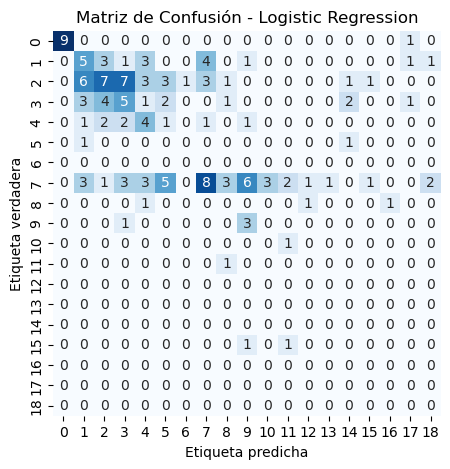

2024/11/03 18:49:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Logistic Regression


/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josuebolanos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Logistic Regression Cross-Validation Accuracy: 0.7393785668991757


Training Random Forest with balanced data...
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Random Forest Accuracy: 0.43243243243243246

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.31      0.26      0.29        19
           2       0.45      0.27      0.34        33
           3       0.35      0.37      0.36        19
           4       0.14      0.17      0.15        12
           5       0.00      0.00      0.00         2
           8       0.53      0.74      0.62        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          64    

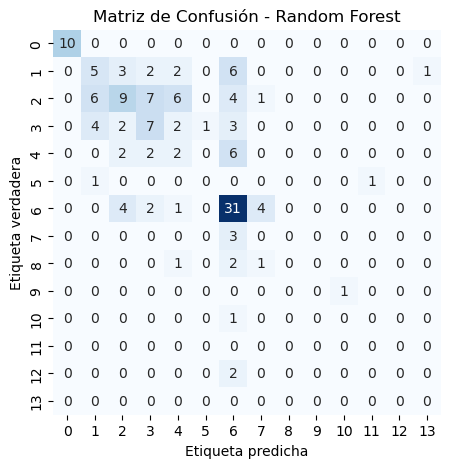

2024/11/03 18:49:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Random Forest
Random Forest Cross-Validation Accuracy: 0.9013950538998098



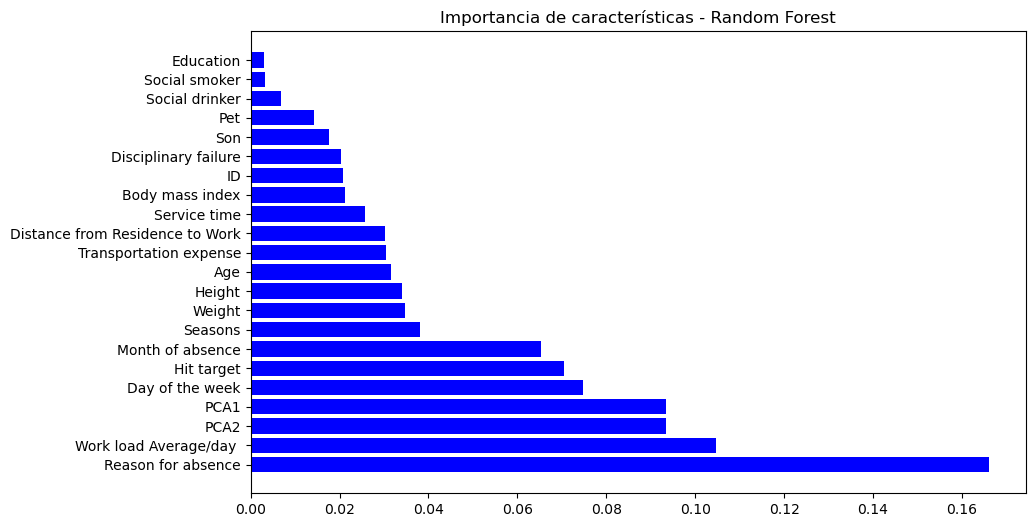

2024/11/03 18:49:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-hen-533 at: http://localhost:5001/#/experiments/8/runs/5ec86c64b4624a7cb591b2a3efdaf030.
2024/11/03 18:49:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/8.



Training Gradient Boosting with balanced data...
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Gradient Boosting Accuracy: 0.4391891891891892

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.37      0.37      0.37        19
           2       0.50      0.36      0.42        33
           3       0.32      0.37      0.34        19
           4       0.15      0.17      0.16        12
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.57      0.62      0.59        42
          16       0.00      0.00      0.00         3
          24       0.50      0.25      0.33         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          64      

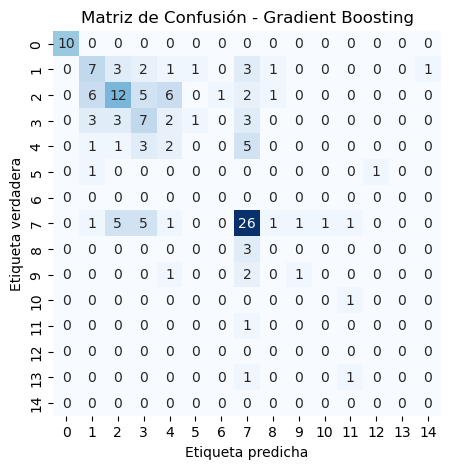

2024/11/03 18:51:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Gradient Boosting
Gradient Boosting Cross-Validation Accuracy: 0.9090044388078631



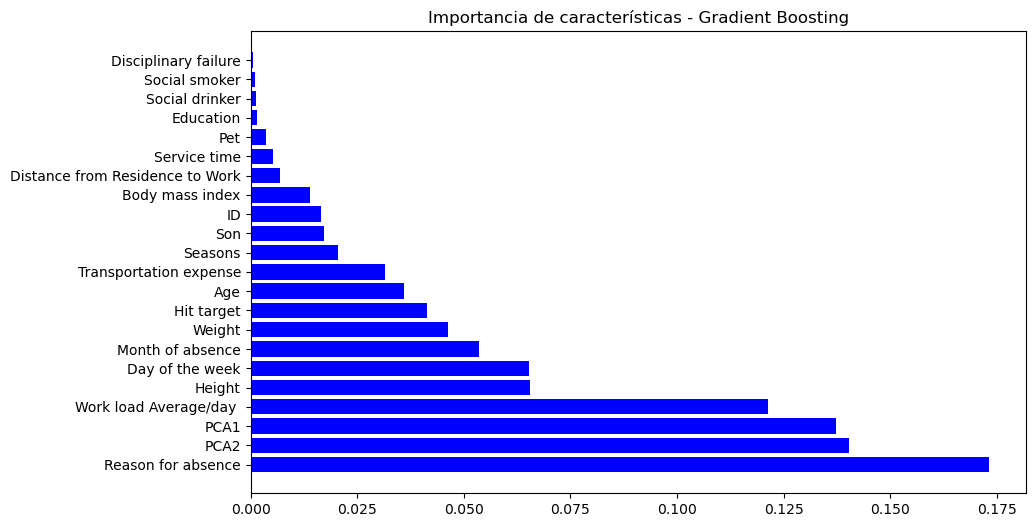

2024/11/03 18:51:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run respected-dog-807 at: http://localhost:5001/#/experiments/9/runs/482b69d0ad2d42cdb1e1cc5f93c9923a.
2024/11/03 18:51:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/9.



Training K-Nearest Neighbors with balanced data...
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
K-Nearest Neighbors Accuracy: 0.33783783783783783

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.24      0.26      0.25        19
           2       0.46      0.33      0.39        33
           3       0.25      0.26      0.26        19
           4       0.28      0.42      0.33        12
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.48      0.31      0.38        42
          16       0.00      0.00      0.00         3
          24       0.50      0.25      0.33         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          48       0.00      0.00      0

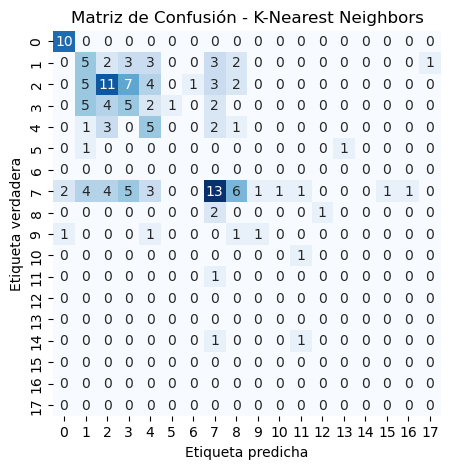

2024/11/03 18:51:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para K-Nearest Neighbors
K-Nearest Neighbors Cross-Validation Accuracy: 0.8874445149017121



2024/11/03 18:51:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-gnu-74 at: http://localhost:5001/#/experiments/10/runs/7ec5eeb01bbf40218b3645f2f65bb989.
2024/11/03 18:51:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/10.


In [13]:
main(filepath=r'./Absenteeism_at_work.csv')

# Correr Modelo Específico

In [14]:
import mlflow
logged_model = 'runs:/865ea83b262f4149a6702b73e025f812/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [15]:
data = DataHandler.load_data(r'./Absenteeism_at_work.csv')
df_cleaned = DataHandler.prepared_data(data)

# Definir las columnas numéricas y categóricas
numeric_columns = ['Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target']
categorical_columns = ['Month of absence', 'Day of the week', 'Seasons', 'Education', 'Disciplinary failure', 'Social drinker', 'Social smoker']

# Preprocesamiento de los datos
preprocessor = Preprocessor()
df_preprocessed = preprocessor.preprocess_data(df_cleaned, numeric_columns, categorical_columns)


# 4. Dividir los datos para entrenamiento y evaluación
model_training = ModelTraining()
X_train, X_test, y_train, y_test = model_training.split_data(df_preprocessed, 'Absenteeism time in hours')

loaded_model.predict(X_test)

1.- Loading and exploring the data
2.- Preparing the data
               ID  Reason for absence  Month of absence  Day of the week  \
count  740.000000          740.000000        740.000000       740.000000   
mean    18.017568           19.216216          6.324324         3.914865   
std     11.021247            8.433406          3.436287         1.421675   
min      1.000000            0.000000          0.000000         2.000000   
25%      9.000000           13.000000          3.000000         3.000000   
50%     18.000000           23.000000          6.000000         4.000000   
75%     28.000000           26.000000          9.000000         5.000000   
max     36.000000           28.000000         12.000000         6.000000   

          Seasons  Transportation expense  Distance from Residence to Work  \
count  740.000000              740.000000                       740.000000   
mean     2.544595              221.329730                        29.631081   
std      1.111831      

array([ 2,  2,  8,  4,  8,  8,  3,  8,  8,  3,  0,  0,  8,  8,  0,  8,  1,
        2,  2,  4,  8,  1,  2,  0,  4,  8,  8,  8,  3,  8,  8,  3,  8,  1,
        8,  3,  8,  1,  2,  8,  8,  8,  8,  2,  2,  2,  8,  8,  4,  1,  2,
        8,  8,  1,  8,  0,  4,  0,  8,  8,  8,  2,  4,  3,  8,  2,  4,  3,
        3,  8, 16,  8,  3,  4,  8,  8,  3,  3,  8,  8,  8,  1,  8,  8,  8,
        0,  4,  8,  8,  8,  1,  0,  4,  3,  8,  2,  2,  2,  8,  1,  2,  8,
        8,  4,  3,  3,  8,  2,  0,  2,  8,  8,  1,  4,  8,  3,  2,  2,  8,
        8,  8,  8,  8,  2,  2,  4,  0,  1,  8,  8,  2,  2,  3,  3,  8,  8,
        8,  1,  8,  3,  1,  4,  8,  3,  1,  2,  2,  1])